# Too Warm?

## Compare the outliers with the Annual Cycle

In [1]:
# imports
from importlib import reload
import os

import numpy as np
from scipy.interpolate import interp1d
from scipy.io import loadmat

import pandas

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import seaborn as sns

from siosandbox.cugn import clusters
from siosandbox.cugn import grid_utils
from siosandbox.cugn import io as cugn_io
from siosandbox import plot_utils
from siosandbox.cugn import annualcycle
from siosandbox.cugn import utils as cugn_utils

from gsw import conversions, density
import gsw

# Load

## Outliers

In [2]:
line = '90'

# Load
items = cugn_io.load_line(line)
grid_tbl = items['grid_tbl']
ds = items['ds']

# Fill
grid_utils.fill_in_grid(grid_tbl, ds)

In [3]:
perc = 80.
grid_outliers, _, _ = grid_utils.gen_outliers(line, perc)

In [4]:
extrem = grid_outliers.SO > 1.1
grid_extrem = grid_outliers[extrem].copy()

In [5]:
grid_extrem.head()

,depth,profile,row,col,doxy,doxy_p,time,lon,lat,z,CT,SA,sigma0,SO,N,chla,T
782,0,32958,15,18,277.438868,99.488491,2017-03-14 02:17:03,-118.227115,33.265208,10,15.488374,33.434623,24.549290,1.116404,7.360446,0.285907,15.456250
783,0,32959,15,18,276.052619,98.976982,2017-03-14 03:41:20,-118.217615,33.270125,10,15.243413,33.434927,24.603163,1.105516,6.704290,0.271055,15.211909
788,0,32964,15,19,298.647665,99.616858,2017-03-14 15:53:33,-118.129770,33.313952,10,14.946715,33.443485,24.673905,1.189120,7.679979,0.324720,14.916154
789,0,32965,13,19,292.036344,99.696970,2017-03-14 18:54:13,-118.106223,33.320505,10,14.787911,33.351972,24.638233,1.158375,13.925959,0.397494,14.755500
790,0,32966,13,17,309.040496,99.794239,2017-03-14 21:51:29,-118.080510,33.323907,10,15.265308,33.331187,24.519477,1.237211,13.226413,0.369575,15.231154


## Annual cycle

In [6]:
anncyc90_file = os.path.join(os.getenv('CUGN'), 'anncyc90.mat')
A = anncyc90 = loadmat(anncyc90_file, variable_names=['A'])['A']

# Evaluate Annual Cycle

## Distance

In [64]:
dist, offset = cugn_utils.calc_dist_offset(line, grid_extrem.lon.values, grid_extrem.lat.values)

In [65]:
grid_extrem['dist'] = dist

In [22]:
dist.min()
np.sum(dist < 0.)

173

## Times

In [15]:
unix_time = (grid_extrem.time - pandas.Timestamp("1970-01-01")) / pandas.Timedelta('1s')
unix_time.values

array([1.48945782e+09, 1.48946288e+09, 1.48950681e+09, ...,
       1.53384183e+09, 1.53541358e+09, 1.53558417e+09])

## DOY

In [33]:
dtime = pandas.to_datetime(grid_extrem.time.values)
dtime.hour

Int64Index([ 2,  3, 15, 18, 21,  0,  3,  6,  9, 12,
            ...
            17, 20, 14,  6,  9, 14, 17, 19, 23, 23],
           dtype='int64', length=1179)

In [39]:
doy_d = dtime.dayofyear + dtime.hour/24. 
doy_d = doy_d.values
doy_d

array([ 73.08333333,  73.125     ,  73.625     , ..., 221.79166667,
       239.95833333, 241.95833333])

## T Annual

In [80]:
# Loop on levels
reload(annualcycle)
uni_depth = np.unique(grid_extrem.depth.values)
T_Annual = np.zeros(unix_time.size)
#
for level in uni_depth:
    in_depth = grid_extrem.depth == level
    print(f"Level: {level}")
    # 
    T_Annual[in_depth] = annualcycle.evaluate(A, 't', level, unix_time[in_depth], dist[in_depth])

Level: 0
Level: 1
Level: 2
Level: 3
Level: 4


In [29]:
T_Annual

array([15.29172197, 15.29357776, 15.29763967, ..., 20.60821379,
       19.16341767, 19.25628033])

## 2020 too

In [67]:
dti = pandas.date_range('2020-01-01', periods=365, freq='1D')
time = (dti - pandas.Timestamp("1970-01-01")) // pandas.Timedelta('1s')
ddist = 100.

T_2021_10 = annualcycle.evaluate(A, 't', 0, time, np.ones_like(time)*ddist)
T_2021_20 = annualcycle.evaluate(A, 't', 1, time, np.ones_like(time)*ddist)
T_2021_30 = annualcycle.evaluate(A, 't', 2, time, np.ones_like(time)*ddist)

# DT

In [81]:
DT = grid_extrem['T'] - T_Annual
grid_extrem['DT'] = DT

# Plots

## Absolute

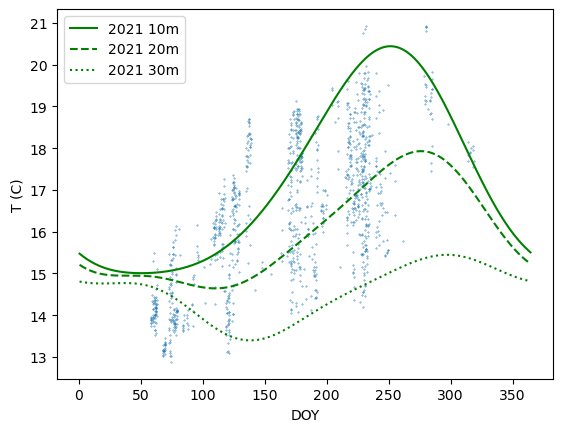

In [82]:
plt.clf()
ax = plt.gca()

# Data
ax.scatter(doy_d, grid_extrem['T'], s=0.1)

# 2021
ax.plot(np.arange(365)+0.5, T_2021_10, 'g-', label='2021 10m')
ax.plot(np.arange(365)+0.5, T_2021_20, 'g--', label='2021 20m')
ax.plot(np.arange(365)+0.5, T_2021_30, 'g:', label='2021 30m')
ax.legend()

ax.set_xlabel('DOY')
ax.set_ylabel('T (C)')

plt.show()

## Relative

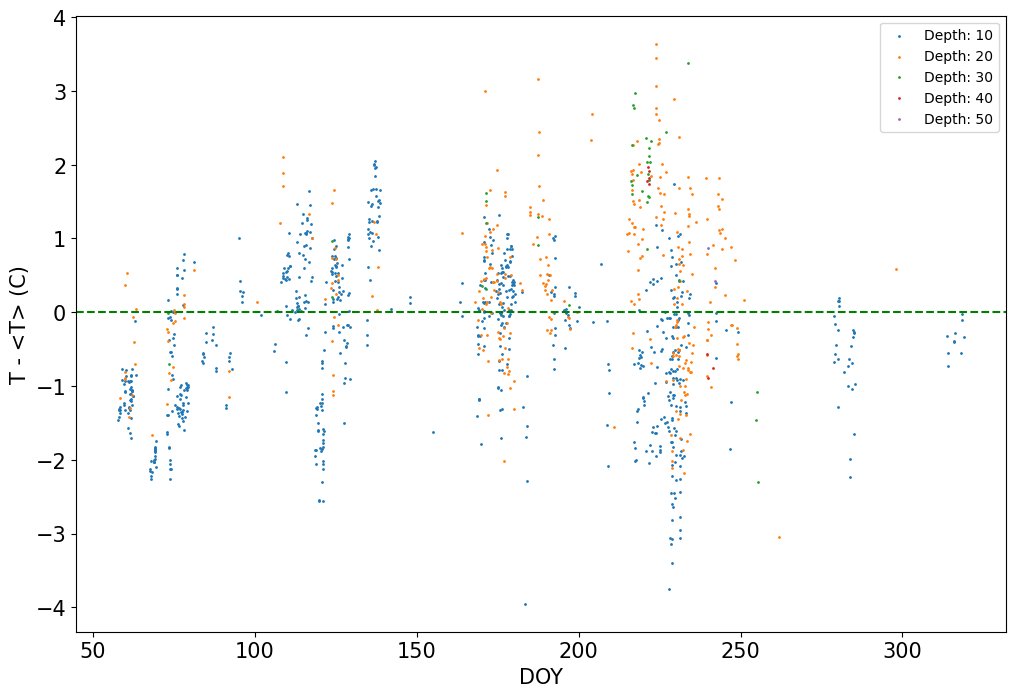

In [98]:
fig = plt.figure(figsize=(12,8))
plt.clf()
ax = plt.gca()

# Data
for depth in [0,1,2,3,4]:
    in_depth = grid_extrem.depth == depth
    sc = ax.scatter(doy_d[in_depth], DT[in_depth], s=1., label=f'Depth: {10+depth*10}') 
#plt.colorbar(sc)

# 2021
ax.legend()

ax.axhline(0., color='g', linestyle='--')

ax.set_xlabel('DOY')
ax.set_ylabel('T - <T> (C)')

# 
plot_utils.set_fontsize(ax, 15.)

plt.show()

# Dig in

In [59]:
too_cold = grid_extrem.DT < -4.
grid_extrem[too_cold].head()

,depth,profile,row,col,doxy,doxy_p,time,lon,lat,z,CT,SA,sigma0,SO,N,chla,T,DT
22599,1,38396,22,24,282.154424,99.318956,2018-06-26 01:24:31,-118.412868,33.200052,20,14.103035,33.713352,25.058093,1.106984,13.069949,0.553384,14.082273,-4.149183
28797,1,44957,23,16,273.556054,98.393574,2020-08-26 19:52:47,-118.221423,33.275428,20,17.091714,33.746142,24.420343,1.137879,15.644876,NaN,17.065545,-4.177228
28806,1,44966,21,18,279.635642,99.354839,2020-08-27 18:38:08,-118.036630,33.336285,20,16.142291,33.683567,24.592270,1.141701,16.402131,NaN,16.116583,-4.472003
28879,1,45039,17,18,277.241163,99.201597,2020-09-04 18:47:27,-117.677868,33.204988,20,15.537487,33.522392,24.605181,1.117398,16.085474,1.665333,15.509000,-4.088198
28881,1,45041,17,18,282.391349,99.600798,2020-09-05 00:42:12,-117.721672,33.222485,20,15.511228,33.523001,24.611437,1.137577,15.040181,2.049000,15.482818,-4.244812


In [68]:
grid_extrem[too_cold].iloc[0]

depth                        1
profile                  38396
row                         22
col                         24
doxy                282.154424
doxy_p               99.318956
time       2018-06-26 01:24:31
lon                -118.412868
lat                  33.200052
z                           20
CT                   14.103035
SA                   33.713352
sigma0               25.058093
SO                    1.106984
N                    13.069949
chla                  0.553384
T                    14.082273
DT                   -4.149183
dist                 71.032691
Name: 22599, dtype: object

In [62]:
grid_extrem[too_cold].iloc[0].dist

100.0

----